In [1]:
import sys
import os
import re
import logging
import subprocess
import signal
import snapatac2 as snap
import pyranges as pr
import pandas as pd


logging.basicConfig(
    format='[%(asctime)s %(levelname)s] %(message)s',
    stream=sys.stdout)
log = logging.getLogger(__name__)

def strip_ext_gz(f):
    return re.sub(r'\.gz$', '', str(f))

def run_shell_cmd(cmd):
    p = subprocess.Popen(
        ['/bin/bash', '-o', 'pipefail'],  # to catch error in pipe
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True,
        preexec_fn=os.setsid)  # to make a new process with a new PGID
    pid = p.pid
    pgid = os.getpgid(pid)
    log.info('run_shell_cmd: PID={}, PGID={}, CMD={}'.format(pid, pgid, cmd))
    stdout, stderr = p.communicate(cmd)
    rc = p.returncode
    err_str = 'PID={}, PGID={}, RC={}\nSTDERR={}\nSTDOUT={}'.format(
        pid, pgid, rc, stderr.strip(), stdout.strip())
    if rc:
        # kill all child processes
        try:
            os.killpg(pgid, signal.SIGKILL)
        except:
            pass
        finally:
            raise Exception(err_str)
    else:
        log.info(err_str)
    return stdout.strip('\n')


def gunzip(f, suffix, out_dir):
    if not f.endswith('.gz'):
        raise Exception('Cannot gunzip a file without .gz extension.')
    gunzipped = os.path.join(out_dir,
                             os.path.basename(strip_ext_gz(f)))
    if suffix:
        gunzipped += '.{}'.format(suffix)
    # cmd = 'gzip -cd {} > {}'.format(f, gunzipped)
    cmd = 'zcat -f {} > {}'.format(f, gunzipped)
    run_shell_cmd(cmd)
    return gunzipped

def rm_f(files):
    if files:
        if type(files) == list:
            run_shell_cmd('rm -f {}'.format(' '.join(files)))
        else:
            run_shell_cmd('rm -f {}'.format(files))

def filter_peaks(
    peaks: pr.PyRanges,
    blacklist: pr.PyRanges,
    score_col: str = "Score",
) -> pr.PyRanges:
    """Filter peaks based on blacklist regions.

    Performs the following operations:
    1. Remove blacklist regions using PyRanges.overlap(invert=True)
    2. Keep only chr1-22, X, Y
    3. Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value

    Parameters
    ----------
    peaks : pr.PyRanges
        Peaks to filter as a PyRanges object.
    blacklist : pr.PyRanges
        Blacklist regions as a PyRanges object.
    
    Returns
    -------
    pr.PyRanges
        Filtered peaks as a PyRanges object.
    """
    # Remove blacklist regions
    peaks = peaks.overlap(blacklist, invert=True)

    # Keep only chr1-22, X, Y
    peaks = peaks[peaks.Chromosome.str.match("chr[1-9]|chr1[0-9]|chr2[0-2]|chrX|chrY")]

    # Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value
    peaks_df = peaks.df.sort_values(score_col, ascending=False).drop_duplicates(["Chromosome", "Start", "End"])

    # Convert back to pyranges
    peaks = pr.PyRanges(peaks_df)

    return peaks

def naive_overlap(
    peaks1: pr.PyRanges,
    peaks2: pr.PyRanges,
    frac: float = None,
    return_overlap: bool = False
) -> tuple:
    """Calculate the overlap between two peaksets.

    Calculates the overlap between two peaksets and returns 3 statistics: 
    1) the number of peaks in the overlap, defined as a any peak in peaks1 that overlaps with a peak in peaks2
    2) the percent of peaks in peaks1 that overlap with peaks2, defined as the number of peaks in the overlap divided by the number of peaks in peaks1
    3) the fraction of the peaks in peaks1 that overlap with peaks2 that are intersecting. Defined as the length of the intersecting part of the peaks 
       in peaks1 that overlap with peaks2, divided by the length of the peaks in peaks1 that overlap with peaks2

    If frac is specified, only peaks in peaks1 that overlap with peaks2 and have a fraction overlap greater than frac will be considered.
    

    Parameters
    ----------
    peaks1 : pr.PyRanges
        First peakset as a PyRanges object.
    peaks2 : pr.PyRanges
        Second peakset as a PyRanges object.

    Returns
    -------
    tuple
        Tuple of overlap number and overlap percent.
    """

    # Get the number of peaks in each peakset
    num_peaks = len(peaks1)

    overlap = peaks1.overlap(peaks2, how="first")  # Peaks in peaks1 that overlap with peaks2
    intersect = peaks1.intersect(peaks2, how="first")  # Part of peaks in peaks1 that overlap with peaks2
    overlap_lengths = overlap.lengths()  # Lengths of overlapping peaks in peaks1
    intersect_lengths = intersect.lengths()  # Lengths of intersecting peaks in peaks1
    frac_overlap = (intersect_lengths/overlap_lengths).values  # Fraction of overlapping peaks in peaks1 that are intersecting peaks

    # Filter by fraction overlap if applicable
    if frac:
        frac_mask = (frac_overlap >= frac)
        overlap = overlap[frac_mask]
        frac_overlap = frac_overlap[frac_mask]


    # Get the number of peaks in the overlap
    overlap_num = len(overlap)

    # Get the percent overlap
    overlap_percent = overlap_num / num_peaks
    
    # Return
    if return_overlap:
        return overlap_num, overlap_percent, frac_overlap, overlap
    else:
        return overlap_num, overlap_percent, frac_overlap

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/merged.h5ads"
peaks_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/peak_matrices/peak_mat.h5ad"
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/cellid_colors.tsv"
condition_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/26Nov23/condition_colors.tsv"
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(h5ad_path)

# Params
umap_key = "X_umap"
embedding_key = "X_spectral"
cell_id_col = "integrated_manual_cellid_annotation"
num_pcs = 10

# Make output directory
os.makedirs(outdir_path, exist_ok=True)

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
0,dm0b,0hr_control,WB_73,WB_74,A2,0,control
1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
2,dm12b,6hr_IFNg,WB_75,WB_76,A2,6,IFNg
3,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
4,dm21a,24hr_3-cyt,WB_11,WB_12,A2,24,3-cyt


In [4]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'SC.beta': '#2a9df4',
 'SC.alpha': '#967bb6',
 'SC.EC': '#ff7f50',
 'SC.delta': '#dc143c',
 'proliferating_alpha': '#ff91a4',
 'other': '#708090'}

In [5]:
# Load in condition colors
condition_colors = pd.read_csv(condition_colors_path, delim_whitespace=True, index_col=0, header=None)
condition_colors = condition_colors.to_dict()[1]
condition_colors

{'control': '#B0B0B0',
 '3-cyt': '#FFA07A',
 'IFNg': '#FF7F50',
 'Ex-4_HG': '#90EE90',
 'palmitate': '#BA55D3',
 'dex': '#ADD8E6'}

In [6]:
# Read in h5ad file
adataset = snap.read_dataset(h5ad_path)
adata = adataset.to_adata()
adata

AnnData object with n_obs × n_vars = 33633 × 606219
    obs: 'sample', 'integrated_manual_cellid_annotation', 'leiden_1'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [7]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_spectral"] = adata.obsm[embedding_key]
adata.obs["cell_id"] = adata.obs[cell_id_col]
adata

AnnData object with n_obs × n_vars = 33633 × 606219
    obs: 'sample', 'integrated_manual_cellid_annotation', 'leiden_1', 'cell_id'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [8]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,sample,integrated_manual_cellid_annotation,leiden_1,cell_id,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm14b#AAACAGCCAATAATCC-1,dm14b,SC.alpha,7,SC.alpha,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACAGCCACCTCAGG-1,dm14b,SC.beta,5,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACATGCATTTAAGC-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAAACAACA-1,dm14b,SC.beta,7,SC.beta,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAGGCTTGT-1,dm14b,SC.EC,1,SC.EC,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG


In [9]:
# Load peak data
adata_peaks = snap.read(peaks_path, backed=None)
adata_peaks

AnnData object with n_obs × n_vars = 33633 × 520861
    obs: 'sample', 'integrated_manual_cellid_annotation', 'leiden_1'

In [10]:
# Merge metadata_peaks
bcs = adata_peaks.obs.index.tolist()
adata_peaks_obs = adata_peaks.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_peaks_obs.index = bcs
adata_peaks.obs = adata_peaks_obs
adata_peaks.obs.head()

,sample,integrated_manual_cellid_annotation,leiden_1,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm14b#AAACAGCCAATAATCC-1,dm14b,SC.alpha,7,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACAGCCACCTCAGG-1,dm14b,SC.beta,5,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACATGCATTTAAGC-1,dm14b,SC.EC,1,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAAACAACA-1,dm14b,SC.beta,7,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
dm14b#AAACCAACAGGCTTGT-1,dm14b,SC.EC,1,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG


In [11]:
# Path to blacklist
blacklist_path = "/cellar/users/aklie/data/ref/blacklists/hg38/temp.bed"
blacklist = pr.read_bed(blacklist_path)
blacklist

,Chromosome,Start,End
0,chr1,627846,636161
1,chr1,5849030,5851628
2,chr1,8908553,8911071
3,chr1,9573523,9576054
4,chr1,32042766,32045260
...,...,...,...
905,chrY,11289740,11335335
906,chrY,11491996,11593907
907,chrY,11669957,11672103
908,chrY,11720471,11750529


In [13]:
adataset.close()

In [17]:
import numpy as np

In [19]:
outdir_path

'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2'

In [20]:
# Randomly sample 1000 peaks (adata.var.index) and save to text file
num_peaks = 100
random_peaks = adata_peaks.var.index.tolist()
random_peaks = np.random.choice(random_peaks, num_peaks, replace=False)
random_peaks = pd.DataFrame(random_peaks)
random_peaks.to_csv(os.path.join(outdir_path, "random_peaks.txt"), sep="\t", index=False, header=False)

In [12]:
# make filter dir
os.makedirs(os.path.join(outdir_path, "filtered_peaks"), exist_ok=True)

# Filter peaks
peaksets = adata.uns["macs3"].copy()

# Rename chrom:Chromosome, start:Start, end:End
for k, v in peaksets.items():
    v = v.to_pandas()
    peaksets[k] = v.rename(columns={"chrom": "Chromosome", "start": "Start", "end": "End"})

# Convert each df in the dict to a PyRanges object
peaksets_pr = {k: pr.PyRanges(v) for k, v in peaksets.items()}

# Filter each peakset
for k, v in peaksets_pr.items():
    peaksets_pr[k] = filter_peaks(v, blacklist, score_col="score")

KeyError: 'macs3'

In [ ]:
# Save filtered peaks to disk in bed format
for k, v in peaksets_pr.items():
    v.to_bed(os.path.join(outdir_path, "filtered_peaks", f"{k}.filt.narrowPeak"))

In [ ]:
# Add consensus peaks from adata_peaks.var_names
consensus_chrom = adata_peaks.var.index.str.split(":").str[0].tolist()
consensus_start = adata_peaks.var.index.str.split(":").str[1].str.split("-").str[0].astype(int).tolist()
consensus_end = adata_peaks.var.index.str.split(":").str[1].str.split("-").str[1].astype(int).tolist()
consensus_df = pd.DataFrame({"Chromosome": consensus_chrom, "Start": consensus_start, "End": consensus_end})
consensus_pr = pr.PyRanges(consensus_df)
peaksets_pr["consensus"] = consensus_pr

In [86]:
k = "consensus"
infile = os.path.join(outdir_path, "peak_calls", f"{k}_peaks.bed")
outfile = os.path.join(outdir_path, "annotated_peaks", f"{k}_peaks.annot.bed")
cmd = f"annotatePeaks.pl {infile} hg38 > {outfile}"
print(cmd)
run_shell_cmd(cmd)

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/peak_calls/consensus_peaks.bed hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/consensus_peaks.annot.bed


2024-01-21 16:03:39 - INFO - run_shell_cmd: PID=2352852, PGID=2352852, CMD=annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/peak_calls/consensus_peaks.bed hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/consensus_peaks.annot.bed
2024-01-21 16:05:05 - INFO - PID=2352852, PGID=2352852, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/peak_calls/consensus_peaks.bed
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 520861
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 520861
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be intege

''

In [43]:
# Annotate peaks
# For each written out file, annotate peaks with the following:
# annotatePeaks.pl $peak_file hg38 > $peak_file.filt.annot.bed"

# Make annotated peaks dir
os.makedirs(os.path.join(outdir_path, "annotated_peaks"), exist_ok=True)

for k, v in peaksets_pr.items():
    infile = os.path.join(outdir_path, "filtered_peaks", f"{k}.filt.narrowPeak")
    outfile = os.path.join(outdir_path, "annotated_peaks", f"{k}.filt.narrowPeak.annot.bed")
    cmd = f"annotatePeaks.pl {infile} hg38 > {outfile}"
    print(cmd)
    run_shell_cmd(cmd)

2024-01-21 13:19:25 - INFO - run_shell_cmd: PID=2337644, PGID=2337644, CMD=annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/other.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/other.filt.narrowPeak.annot.bed


annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/other.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/other.filt.narrowPeak.annot.bed


2024-01-21 13:20:18 - INFO - PID=2337644, PGID=2337644, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/other.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 158589
		peakfile formatted lines: 0
		Duplicated Peak IDs: 158588

	Peak File Statistics:
		Total Peaks: 158589
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	1964.0	26833139	0.510	-114.223
		miRNA	20.0	97618	1.995	-14.831
		ncRNA	914.0	7044070	1.336	-

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/proliferating_alpha.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/proliferating_alpha.filt.narrowPeak.annot.bed


2024-01-21 13:21:05 - INFO - PID=2337789, PGID=2337789, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/proliferating_alpha.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 97935
		peakfile formatted lines: 0
		Duplicated Peak IDs: 97934

	Peak File Statistics:
		Total Peaks: 97935
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	1118.0	26833139	0.393	-41.326
		miRNA	10.0	97618	1.691	-6.577
		ncRNA	630.0	704407

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.EC.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/SC.EC.filt.narrowPeak.annot.bed


2024-01-21 13:22:19 - INFO - PID=2337828, PGID=2337828, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.EC.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 402486
		peakfile formatted lines: 0
		Duplicated Peak IDs: 402485

	Peak File Statistics:
		Total Peaks: 402486
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	5471.0	26833139	0.645	-482.452
		miRNA	34.0	97618	1.417	-14.373
		ncRNA	1834.0	7044070	0.998	

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.beta.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/SC.beta.filt.narrowPeak.annot.bed


2024-01-21 13:23:36 - INFO - PID=2337994, PGID=2337994, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.beta.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 403225
		peakfile formatted lines: 0
		Duplicated Peak IDs: 403224

	Peak File Statistics:
		Total Peaks: 403225
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	5694.0	26833139	0.700	-583.789
		miRNA	31.0	97618	1.281	-11.430
		ncRNA	1846.0	7044070	1.00

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.alpha.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/SC.alpha.filt.narrowPeak.annot.bed


2024-01-21 13:24:43 - INFO - PID=2338045, PGID=2338045, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.alpha.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 321518
		peakfile formatted lines: 0
		Duplicated Peak IDs: 321517

	Peak File Statistics:
		Total Peaks: 321518
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	4576.0	26833139	0.711	-483.969
		miRNA	30.0	97618	1.561	-14.857
		ncRNA	1526.0	7044070	1.0

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.delta.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/annotated_peaks/SC.delta.filt.narrowPeak.annot.bed


2024-01-21 13:25:28 - INFO - PID=2338210, PGID=2338210, RC=0
STDERR=Peak file = /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/2024_01_20/condition_within_batch/ext4/snapatac2/filtered_peaks/SC.delta.filt.narrowPeak
	Genome = hg38
	Organism = human
	Peak/BED file conversion summary:
		BED/Header formatted lines: 68353
		peakfile formatted lines: 0
		Duplicated Peak IDs: 68352

	Peak File Statistics:
		Total Peaks: 68353
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	724.0	26833139	0.285	-15.886
		miRNA	5.0	97618	1.210	-2.682
		ncRNA	391.0	7044070	1.326	-128.

In [94]:
# Load in each of the annotated peaks as a dict of dataframes
annotation_counts_df = pd.DataFrame(index=["3' UTR", "5' UTR", 'Intergenic', 'TTS', 'exon', 'intron', 'non-coding', 'promoter-TSS'])
annotated_peaks = {}
for k, v in peaksets_pr.items():
    if k == "consensus":
        curr_df = pd.read_csv(os.path.join(outdir_path, "annotated_peaks", f"{k}_peaks.annot.bed"), sep="\t")
    else:
        curr_df = pd.read_csv(os.path.join(outdir_path, "annotated_peaks", f"{k}.filt.narrowPeak.annot.bed"), sep="\t")
    annotation_counts = curr_df["Annotation"].str.split("(").str[0].str.strip().value_counts().sort_index()
    annotation_counts.name = k
    annotation_counts_df = annotation_counts_df.merge(annotation_counts, left_index=True, right_index=True)
annotated_peaks

{}

In [101]:
adata.obs.cell_id.value_counts()

cell_id
SC.EC                  11518
SC.beta                10968
SC.alpha                9171
other                   1608
proliferating_alpha      280
SC.delta                  88
Name: count, dtype: int64

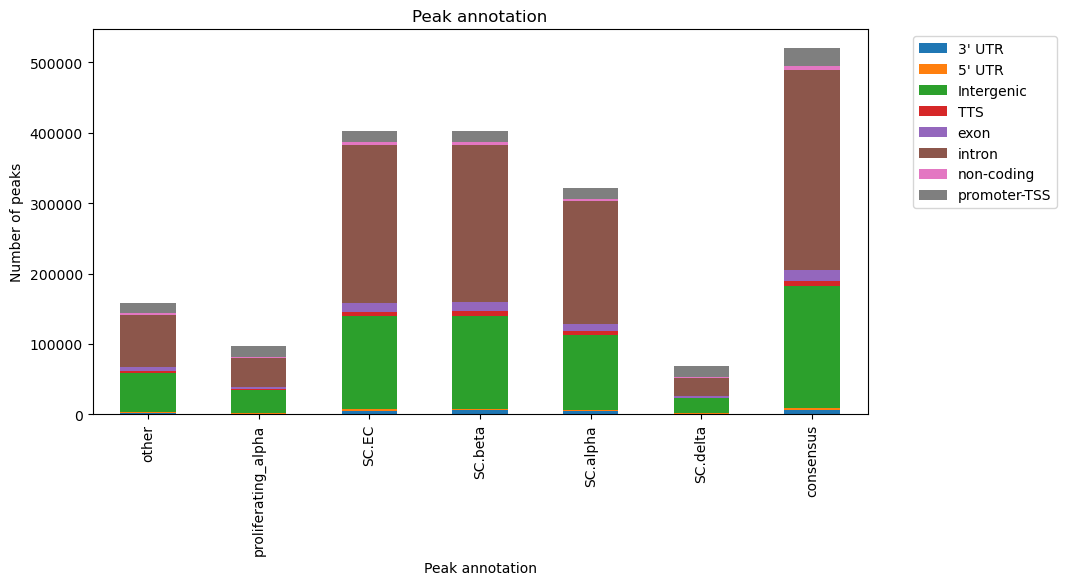

In [97]:
# Make a stacked barplot of the annotated peaks
annotation_counts_df = annotation_counts_df.T

# Plot
ax = annotation_counts_df.plot.bar(stacked=True, figsize=(10, 5))
ax.set_ylabel("Number of peaks")
ax.set_xlabel("Peak annotation")
ax.set_title("Peak annotation")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [48]:
# Fraction of reads in peaks
regions = {}
for peakset in peaksets:
    regions[peakset] = peaksets[peakset].apply(lambda x: f"{x[0]}:{x[1]}-{x[2]}", axis=1)
    regions[peakset] = regions[peakset].values
snap.metrics.frip(adataset, regions=regions, n_jobs=-1)

In [109]:
peaksets

{'other':        Chromosome     Start       End name  score strand  signal_value  \
 0            chr1      9919     10555    .    978      .     20.491804   
 1            chr1      9919     10555    .    456      .     12.295082   
 2            chr1      9919     10555    .    616      .     14.959017   
 3            chr1     29281     29455    .     50      .      3.986280   
 4            chr1    180680    181811    .    181      .      7.142857   
 ...           ...       ...       ...  ...    ...    ...           ...   
 213598       chrY  20575430  20576231    .   1000      .     17.733992   
 213599       chrY  26409010  26409172    .     24      .      3.048331   
 213600       chrY  26671072  26671125    .     19      .      2.813844   
 213601       chrY  56763489  56763561    .     24      .      3.048331   
 213602       chrY  56836732  56836922    .     43      .      3.632479   
 
            p_value     q_value  peak  
 0       100.754890   97.873451   175  
 1       

In [55]:
adata_frip = adataset.to_adata()

In [64]:
adata_frip.obs['cell_id'] = adata_frip.obs[cell_id_col]

In [66]:
frip_df = adata_frip.obs[['cell_id', 'SC.EC', 'SC.alpha', 'SC.beta', 'SC.delta', 'other', 'proliferating_alpha']]

In [106]:
import seaborn as sns

<Axes: ylabel='cell_id'>

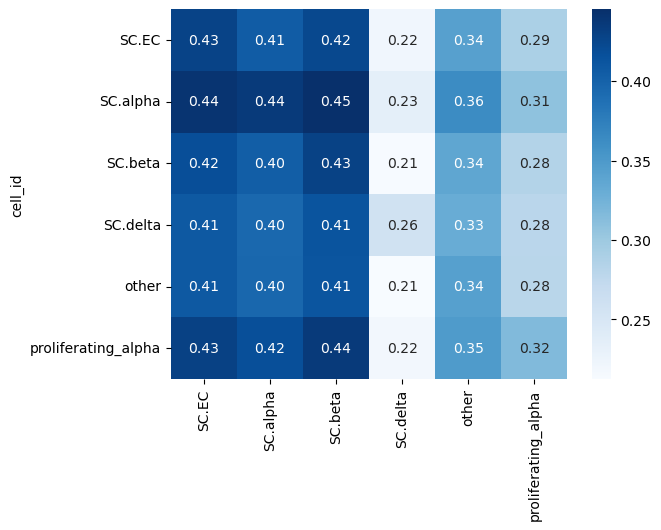

In [108]:
# For each cell type, calculate the mean FRiP for each peakset
mean_frip = frip_df.groupby("cell_id").mean()

# Plot as heatmap
sns.heatmap(mean_frip, cmap="Blues", annot=True, fmt=".2f")

In [69]:
frip_df_long = frip_df.melt(id_vars=['cell_id'], var_name='peakset', value_name='frip')

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='peakset', ylabel='frip'>

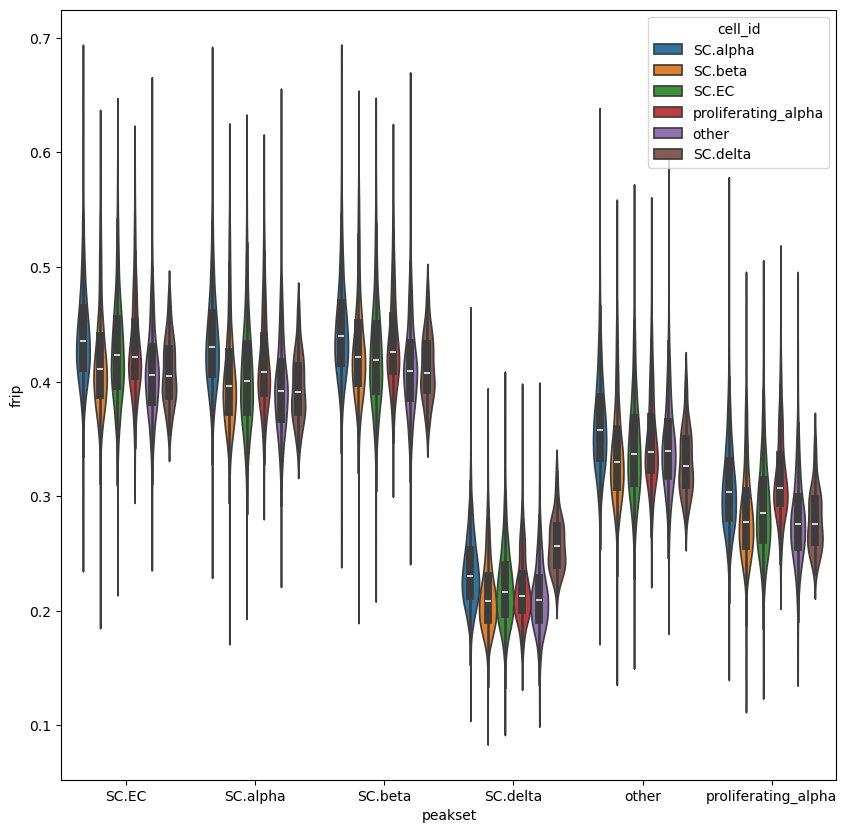

In [76]:
# Plot violin plots of frip separated by peakset
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(x="peakset", y="frip", hue="cell_id", data=frip_df_long, ax=ax)

In [46]:
# Find marker peaks
marker_peaks = snap.tl.marker_regions(adata_peaks, groupby='integrated_manual_cellid_annotation', pvalue=0.05)

2024-01-21 14:04:35 - WARNING - Input contains 158773 peaks, only 50000 peaks will be plotted.


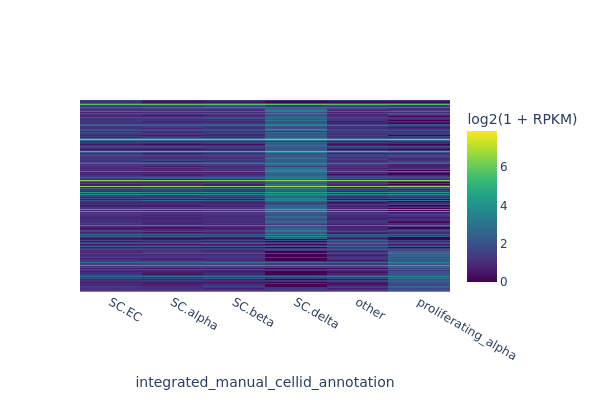

In [47]:
snap.pl.regions(adata_peaks, groupby='integrated_manual_cellid_annotation', peaks=marker_peaks, interactive=False)

# Peak set overlap

In [113]:
peaksets

{'other':        Chromosome     Start       End name  score strand  signal_value  \
 0            chr1      9919     10555    .    978      .     20.491804   
 1            chr1      9919     10555    .    456      .     12.295082   
 2            chr1      9919     10555    .    616      .     14.959017   
 3            chr1     29281     29455    .     50      .      3.986280   
 4            chr1    180680    181811    .    181      .      7.142857   
 ...           ...       ...       ...  ...    ...    ...           ...   
 213598       chrY  20575430  20576231    .   1000      .     17.733992   
 213599       chrY  26409010  26409172    .     24      .      3.048331   
 213600       chrY  26671072  26671125    .     19      .      2.813844   
 213601       chrY  56763489  56763561    .     24      .      3.048331   
 213602       chrY  56836732  56836922    .     43      .      3.632479   
 
            p_value     q_value  peak  
 0       100.754890   97.873451   175  
 1       

In [129]:
# Loop through and calculate overlap between each pair of samples
overlap_df = pd.DataFrame(columns=["sample1", "sample2", "num_overlapping_peaks", "overlap_pct", "avg_overlap_pct"])
intersect_peaks_dict = {}
intersect_frac_overlap_dict = {}
for i in range(len(peaksets_pr)):
    for j in range(len(peaksets_pr)):
        sample1, sample2 = list(peaksets_pr.keys())[i], list(peaksets_pr.keys())[j]
        if sample1 == "consensus" or sample2 == "consensus":
            continue
        sample1_peaks, sample2_peaks = peaksets_pr[sample1], peaksets_pr[sample2]
        overlap_num, overlap_pct, frac_overlap, overlap = naive_overlap(sample1_peaks, sample2_peaks, frac=0.5, return_overlap=True)
        overlap_df.loc[i*len(peaksets_pr)+j] = [sample1, sample2, overlap_num, overlap_pct, frac_overlap.mean()]
        intersect_peaks_dict[(sample1, sample2)] = overlap
        intersect_frac_overlap_dict[(sample1, sample2)] = frac_overlap

In [130]:
pct_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="overlap_pct").astype(float)

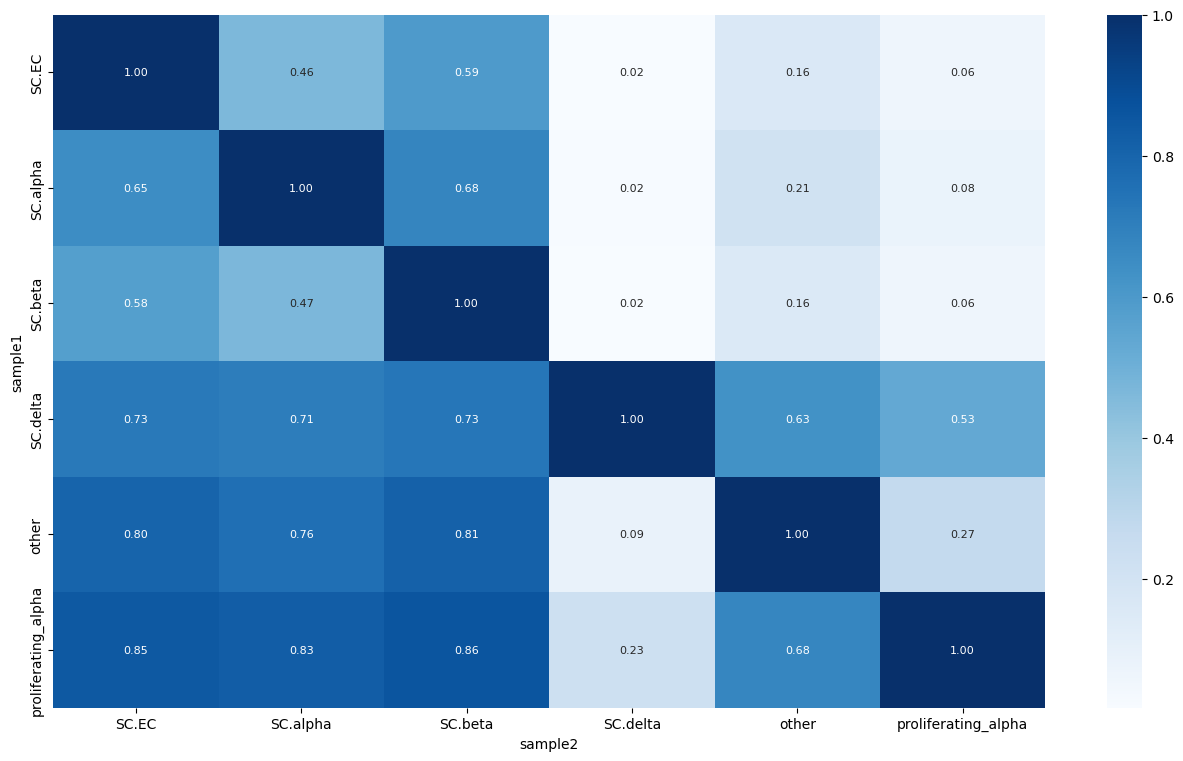

In [132]:
# Heatmap of percent of overlapping peaks, make font size smaller for annot
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(pct_overlap_df, cmap="Blues", annot=True, fmt=".2f", ax=ax, annot_kws={"size": 8})
plt.show()